# Task 2: Hyperelasticity



In [1]:
from matplotlib import pyplot as plt
import tensorflow as tf
import datetime
now = datetime.datetime.now

import importlib


### Data import

In [2]:
import numpy as np

import tensorflow as tf

def compute_invariants(F):
    F = tf.convert_to_tensor(F, dtype=tf.float32)
    # F shape is (batch_size, 3, 3)
    batch_size = tf.shape(F)[0]
    
    # 计算右 Cauchy-Green 张量 C = F^T * F
    # Using einsum for batch matrix multiplication
    C = tf.einsum('bij,bjk->bik', tf.transpose(F, perm=[0, 2, 1]), F)
    
    # 计算不变量 I1, I2 和 J
    I1 = tf.linalg.trace(C)  # shape: (batch_size,)
    
    # For I2, compute trace(C@C) with batch operation
    C_square = tf.einsum('bij,bjk->bik', C, C)
    I2 = 0.5 * (I1**2 - tf.linalg.trace(C_square))  # shape: (batch_size,)
    
    # Compute determinant for each matrix in the batch
    J = tf.linalg.det(F)  # shape: (batch_size,)
    
    # 定义结构张量 Gti
    Gti = tf.constant([
        [4, 0, 0],
        [0, 0.5, 0],
        [0, 0, 0.5]
    ], dtype=tf.float32)
    
    # 扩展 Gti 到批量维度
    Gti = tf.tile(Gti[None, :, :], [batch_size, 1, 1])
    
    # 计算不变量 I4
    I4 = tf.linalg.trace(tf.einsum('bij,bjk->bik', C, Gti))  # shape: (batch_size,)
    
    # 计算 C 的余因子（Cofactor）
    # First compute inverse of C for each matrix in batch
    I3 = tf.linalg.det(C)

# 使用 I3 和 C 的逆计算 Cofactor 矩阵
    Cof_C = I3[:, None, None] * tf.linalg.inv(C)

    # 计算不变量 I5
    I5 = tf.linalg.trace(tf.einsum('bij,bjk->bik', Cof_C, Gti))  # shape: (batch_size,)
    
    return I1, J, I4, I5

In [3]:
data_biaxial = np.loadtxt('../../calibration/biaxial.txt')
data_pure_shear = np.loadtxt('../../calibration/pure_shear.txt')
data_uniaxial = np.loadtxt('../../calibration/uniaxial.txt')


def process_data(data):

    F = data[:, :9].reshape(-1, 3, 3) 
    P = data[:, 9:18].reshape(-1, 3, 3)  
    W = data[:, 18] 
    return F, P, W

# 分别处理三种加载路径的数据
F_biaxial, P_biaxial, W_biaxial = process_data(data_biaxial)
F_pure_shear, P_pure_shear, W_pure_shear = process_data(data_pure_shear)
F_uniaxial, P_uniaxial, W_uniaxial = process_data(data_uniaxial)

In [4]:

I1_data_biaxial,J_data_biaxial,I4_data_biaxial,I5_data_biaxial = compute_invariants(F_biaxial) 
I1_data_pure_shear,J_data_pure_shear,I4_data_pure_shear,I5_data_pure_shear = compute_invariants(F_pure_shear)
I1_data_uniaxial,J_data_uniaxial,I4_data_uniaxial,I5_data_uniaxial = compute_invariants(F_uniaxial)

In [5]:
data_biaxial_test = np.loadtxt('../../test/biax_test.txt')
data_mixed_test = np.loadtxt('../../test/mixed_test.txt')

F_mixed_test, P_mixed_test, W_mixed_test = process_data(data_mixed_test)
F_biaxial_test, P_biaxial_test, W_biaxial_test = process_data(data_biaxial_test)
I1_data_biaxial_test,J_data_biaxial_test,I4_data_biaxial_test,I5_data_biaxial_test = compute_invariants(F_biaxial_test)
I1_data_mixed_test,J_data_mixed_test,I4_data_mixed_test,I5_data_mixed_test = compute_invariants(F_mixed_test)

In [6]:
import numpy as np

# 组合训练数据
I_train_biaxial = np.column_stack((I1_data_biaxial, J_data_biaxial, -J_data_biaxial, I4_data_biaxial, I5_data_biaxial))
I_train_pure_shear = np.column_stack((I1_data_pure_shear, J_data_pure_shear, -J_data_pure_shear, I4_data_pure_shear, I5_data_pure_shear))
I_train_uniaxial = np.column_stack((I1_data_uniaxial, J_data_uniaxial, -J_data_uniaxial, I4_data_uniaxial, I5_data_uniaxial))

# 将所有训练数据组合成一个整体训练集
I_train = np.concatenate([I_train_biaxial, I_train_pure_shear, I_train_uniaxial], axis=0)

# 组合测试数据
I_test_biaxial = np.column_stack((I1_data_biaxial_test, J_data_biaxial_test, -J_data_biaxial_test, I4_data_biaxial_test, I5_data_biaxial_test))
I_test_mixed = np.column_stack((I1_data_mixed_test, J_data_mixed_test, -J_data_mixed_test, I4_data_mixed_test, I5_data_mixed_test))

# 将所有测试数据组合成一个整体测试集
I_test = np.concatenate([I_test_mixed, I_test_biaxial], axis=0)


In [7]:
W_train = np.concatenate([W_biaxial, W_pure_shear, W_uniaxial], axis=0)

In [8]:
I_train_tensor = tf.convert_to_tensor(I_train, dtype=tf.float32)
W_train_tensor = tf.convert_to_tensor(W_train, dtype=tf.float32)
I_test_tensor = tf.convert_to_tensor(I_test, dtype=tf.float32)

### Load model

In [9]:
# %% Own modules
import models as lm
importlib.reload(lm)
model1 = lm.main()

model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 private_c_to_p (_C_to_P)    (None, 1)                 49        
                                                                 
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


Epoch 1/2500
21/21 [==============================] - 1s 4ms/step - loss: 630.3193
Epoch 2/2500
21/21 [==============================] - 0s 3ms/step - loss: 614.4713
Epoch 3/2500
21/21 [==============================] - 0s 3ms/step - loss: 600.2096
Epoch 4/2500
21/21 [==============================] - 0s 3ms/step - loss: 580.9488
Epoch 5/2500
21/21 [==============================] - 0s 3ms/step - loss: 553.8461
Epoch 6/2500
21/21 [==============================] - 0s 4ms/step - loss: 519.8163
Epoch 7/2500
21/21 [==============================] - 0s 4ms/step - loss: 476.7284
Epoch 8/2500
21/21 [==============================] - 0s 3ms/step - loss: 431.8425
Epoch 9/2500
21/21 [==============================] - 0s 3ms/step - loss: 385.9663
Epoch 10/2500
21/21 [==============================] - 0s 3ms/step - loss: 343.3482
Epoch 11/2500
21/21 [==============================] - 0s 3ms/step - loss: 309.5803
Epoch 12/2500
21/21 [==============================] - 0s 3ms/step - loss: 280.8131
E

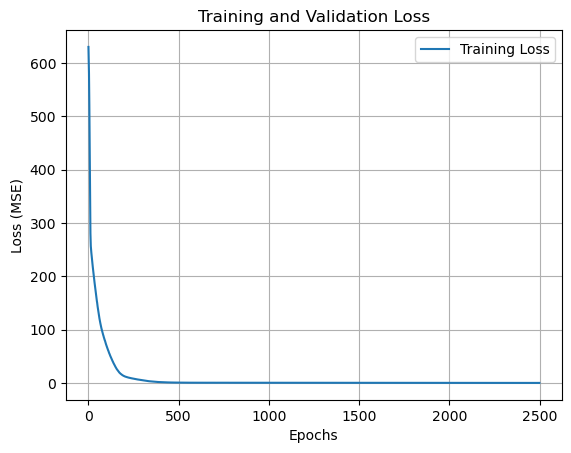

In [10]:

# 模型训练
history = model1.fit(I_train_tensor, W_train_tensor, epochs=2500)

# 训练过程的可视化
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title("Training and Validation Loss")
plt.grid(True)
plt.show()


In [24]:
def compute_stress_tensor(F,model):
    F = tf.convert_to_tensor(F, dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(F)
        

        I1, J, I4, I5 = compute_invariants(F)
        I_train = tf.stack([I1, J, -J, I4, I5], axis=1)
        W_pred = model(I_train)

    # 使用自动微分计算应力张量 P = dW/dF
    P = tape.gradient(W_pred, F)
    
    # 打印 P 以调试
    #print("P:", P)
    
    return P

In [ ]:
P_biaxial_test_pred = compute_stress_tensor(F_biaxial_test,model1)
P_mixed_test_pred = compute_stress_tensor(F_mixed_test, model1)
P_biaxial_pred = compute_stress_tensor(F_biaxial, model1)
P_pure_shear_pred = compute_stress_tensor(F_pure_shear, model1)
P_uniaxial_pred = compute_stress_tensor(F_uniaxial, model1)

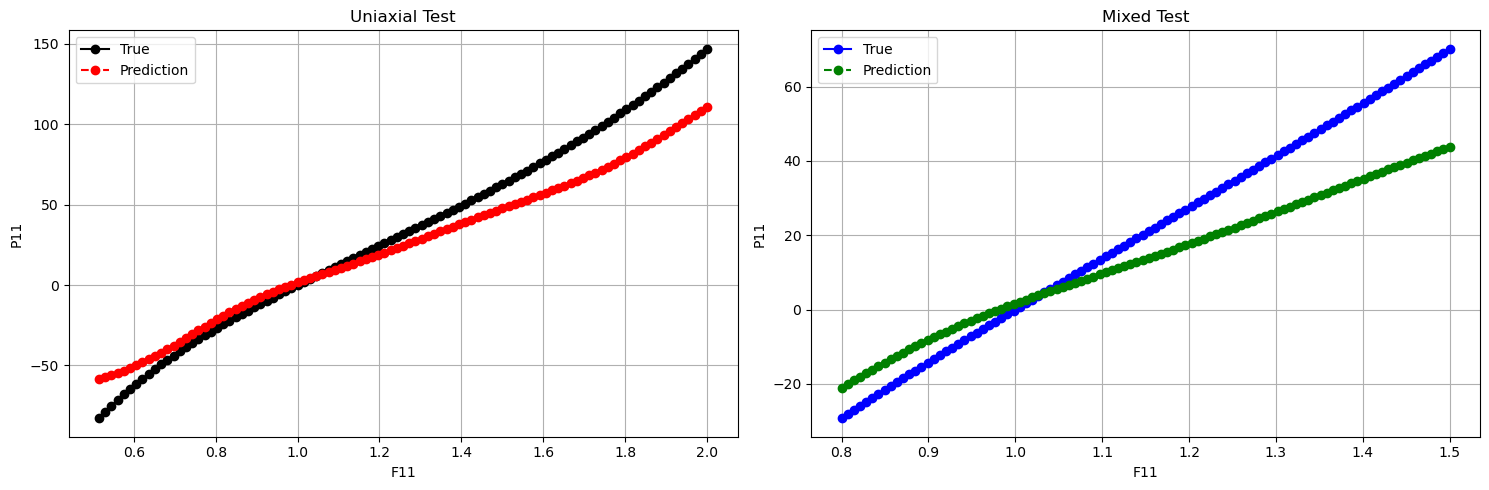

In [13]:

def plot_all_stress_vs_deformation(F_biaxial_test, P_biaxial_test, P_biaxial_test_pred, 
                                 F_mixed_test, P_mixed_test, P_mixed_test_pred):

    F11_biaxial_test = F_biaxial_test[:, 0, 0]
    P11_biaxial_test = P_biaxial_test[:, 0, 0]
    P11_biaxial_test_pred = P_biaxial_test_pred[:, 0, 0]

    F11_mixed_test = F_mixed_test[:, 0, 0]
    P11_mixed_test = P_mixed_test[:, 0, 0]
    P11_mixed_test_pred = P_mixed_test_pred[:, 0, 0]


    # 创建一个包含三个子图的图形
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # 绘制双轴加载
    ax1.plot(F11_biaxial_test, P11_biaxial_test, label="True", marker="o", linestyle="-", color="black")
    ax1.plot(F11_biaxial_test, P11_biaxial_test_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax1.set_xlabel("F11")
    ax1.set_ylabel("P11")
    ax1.set_title("Uniaxial Test")
    ax1.legend()
    ax1.grid(True)

    # 绘制纯剪切加载
    ax2.plot(F11_mixed_test, P11_mixed_test, label="True", marker="o", linestyle="-", color="blue")
    ax2.plot(F11_mixed_test, P11_mixed_test_pred, label="Prediction", marker="o", linestyle="--", color="green")
    ax2.set_xlabel("F11")
    ax2.set_ylabel("P11")
    ax2.set_title("Mixed Test")
    ax2.legend()
    ax2.grid(True)

    # 调整子图之间的间距
    plt.tight_layout()
    plt.show()

# 调用函数绘制三种加载路径的结果
plot_all_stress_vs_deformation(F_biaxial_test, P_biaxial_test, P_biaxial_test_pred, 
                             F_mixed_test, P_mixed_test, P_mixed_test_pred)

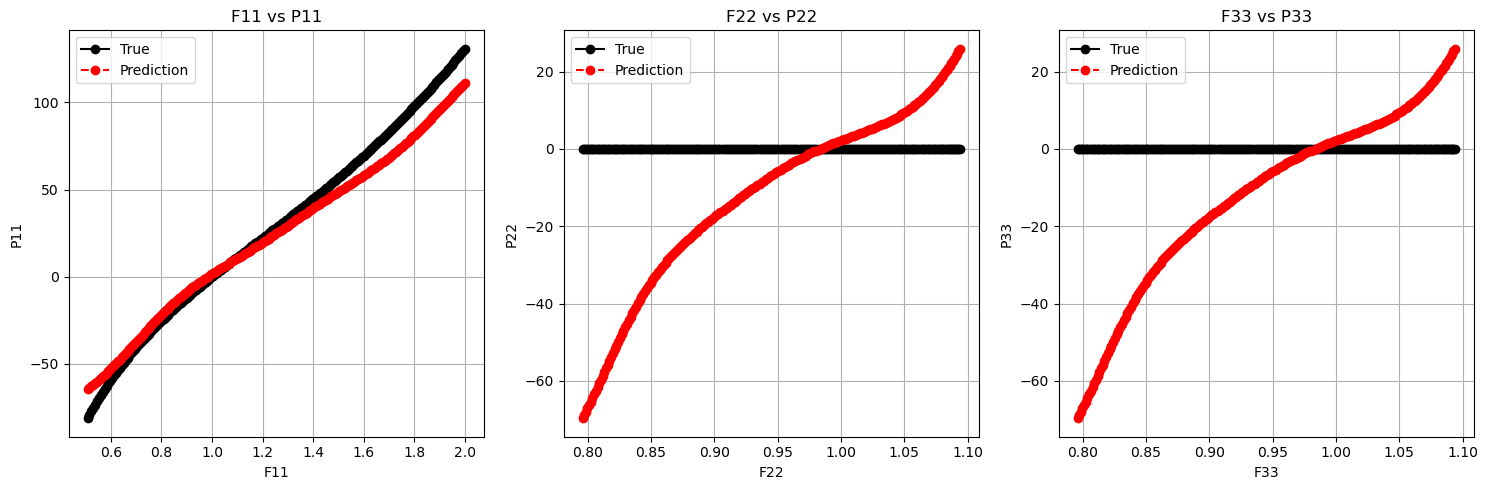

In [17]:
def plot_all_stress_vs_deformation(F_uniaxial, P_uniaxial, P_uniaxial_pred):
    # 提取 F 和 P 的不同分量
    F11 = F_uniaxial[:, 0, 0]  # 第一列
    F22 = F_uniaxial[:, 1, 1]  
    F33 = F_uniaxial[:, 2, 2] # 第三列

    P11 = P_uniaxial[:, 0, 0]  # 原始 P 的 11 元素
    P22 = P_uniaxial[:, 1, 1]  # 原始 P 的 22 元素
    P33 = P_uniaxial[:, 2, 2]  # 原始 P 的 33 元素

    P11_pred = P_uniaxial_pred[:, 0, 0]  # 预测 P 的 11 元素
    P22_pred = P_uniaxial_pred[:, 1, 1]  # 预测 P 的 22 元素
    P33_pred = P_uniaxial_pred[:, 2, 2]  # 预测 P 的 33 元素

    # 创建绘图
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    ax1 = axes[0]
    ax2 = axes[1]
    ax3 = axes[2]

    ax1.plot(F11, P11, label="True", marker="o", linestyle="-", color="black")
    ax1.plot(F11, P11_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax1.set_xlabel("F11")
    ax1.set_ylabel("P11")
    ax1.set_title("F11 vs P11")
    ax1.legend()
    ax1.grid(True)

    ax2.plot(F22, P22, label="True", marker="o", linestyle="-", color="black")
    ax2.plot(F22, P22_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax2.set_xlabel("F22")
    ax2.set_ylabel("P22")
    ax2.set_title("F22 vs P22")
    ax2.legend()
    ax2.grid(True)

    ax3.plot(F33, P33, label="True", marker="o", linestyle="-", color="black")
    ax3.plot(F33, P33_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax3.set_xlabel("F33")
    ax3.set_ylabel("P33")
    ax3.set_title("F33 vs P33")
    ax3.legend()
    ax3.grid(True)

    # 调整布局
    plt.tight_layout()
    plt.show()

# 调用函数
plot_all_stress_vs_deformation(F_uniaxial, P_uniaxial, P_uniaxial_pred)


### Calibrate the model using both

In [53]:
optimizer = tf.optimizers.Adam(learning_rate=0.001)

# 训练步骤
def train_step(F, P_true, model):
    with tf.GradientTape(persistent=True) as tape:  # 使用 persistent=True
        tape.watch(F)
        
        # 计算输入 F 的不变量，并通过模型进行预测
        I1, J, I4, I5 = compute_invariants(F)
        I_train = tf.stack([I1, J, -J, I4, I5], axis=1)
        W_pred = model(I_train)
        
        # 计算应力张量 P = dW/dF
        P_pred = tape.gradient(W_pred, F)
        
        # 计算 MSE 损失
        loss = tf.reduce_mean(tf.square(P_pred - P_true))  # 计算 MSE
        
    # 计算梯度并优化
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return loss

In [49]:
F_train = np.concatenate([F_biaxial, F_pure_shear, F_uniaxial], axis=0)
P_train = np.concatenate([P_biaxial, P_pure_shear, P_uniaxial], axis=0)
F_train_tensor = tf.convert_to_tensor(F_train, dtype=tf.float32)
P_train_tensor = tf.convert_to_tensor(P_train, dtype=tf.float32)

In [54]:
for epoch in range(2000):
    # 假设 F_train 和 P_true_train 是训练集的变形梯度和真实应力张量
    loss = train_step(F_train_tensor, P_train_tensor, model1)
    print(f"Epoch {epoch+1}, Loss: {loss.numpy()}")

Epoch 1, Loss: 392.73846435546875
Epoch 2, Loss: 388.65045166015625
Epoch 3, Loss: 384.58599853515625
Epoch 4, Loss: 380.544677734375
Epoch 5, Loss: 376.52703857421875
Epoch 6, Loss: 372.53411865234375
Epoch 7, Loss: 368.5667419433594
Epoch 8, Loss: 364.6258239746094
Epoch 9, Loss: 360.7123718261719
Epoch 10, Loss: 356.8273010253906
Epoch 11, Loss: 352.9715270996094
Epoch 12, Loss: 349.1459045410156
Epoch 13, Loss: 345.3515625
Epoch 14, Loss: 341.5893249511719
Epoch 15, Loss: 337.8601379394531
Epoch 16, Loss: 334.16485595703125
Epoch 17, Loss: 330.5044860839844
Epoch 18, Loss: 326.8800048828125
Epoch 19, Loss: 323.2921142578125
Epoch 20, Loss: 319.7418518066406
Epoch 21, Loss: 316.2300720214844
Epoch 22, Loss: 312.757568359375
Epoch 23, Loss: 309.3253173828125
Epoch 24, Loss: 305.93408203125
Epoch 25, Loss: 302.5846252441406
Epoch 26, Loss: 299.2778625488281
Epoch 27, Loss: 296.014404296875
Epoch 28, Loss: 292.7950744628906
Epoch 29, Loss: 289.6205749511719
Epoch 30, Loss: 286.49154663

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title("Training and Validation Loss")
plt.grid(True)
plt.show()

In [55]:
P_biaxial_test_pred = compute_stress_tensor(F_biaxial_test,model1)
P_mixed_test_pred = compute_stress_tensor(F_mixed_test, model1)
P_biaxial_pred = compute_stress_tensor(F_biaxial, model1)
P_pure_shear_pred = compute_stress_tensor(F_pure_shear, model1)
P_uniaxial_pred = compute_stress_tensor(F_uniaxial, model1)

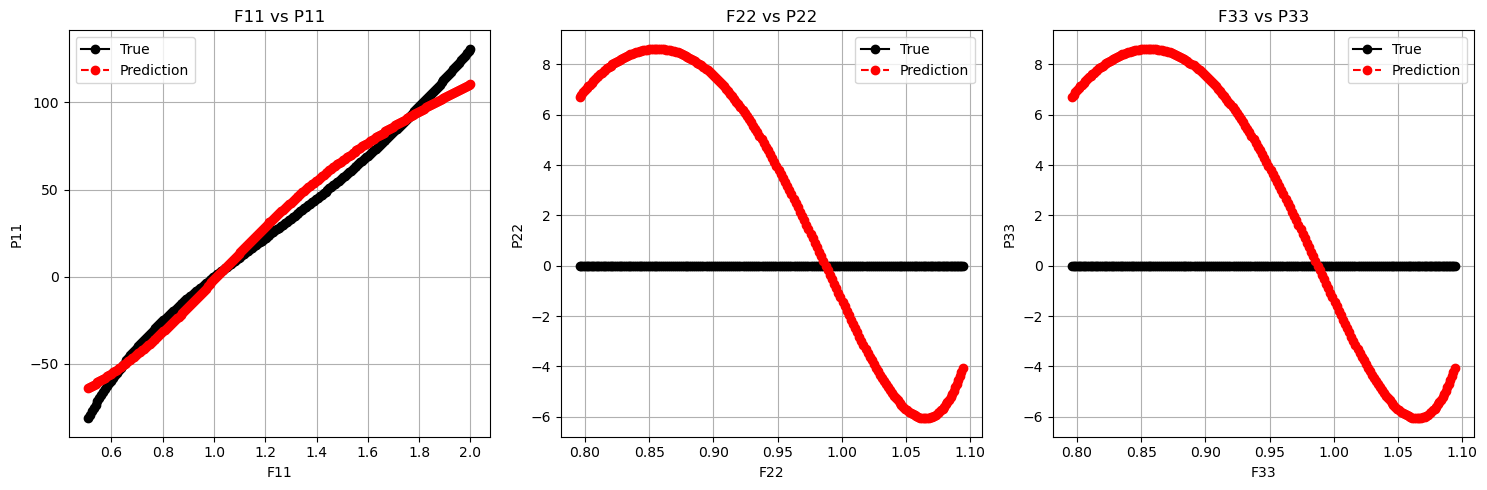

In [56]:
def plot_all_stress_vs_deformation(F_uniaxial, P_uniaxial, P_uniaxial_pred):
    # 提取 F 和 P 的不同分量
    F11 = F_uniaxial[:, 0, 0]  # 第一列
    F22 = F_uniaxial[:, 1, 1]  
    F33 = F_uniaxial[:, 2, 2] # 第三列

    P11 = P_uniaxial[:, 0, 0]  # 原始 P 的 11 元素
    P22 = P_uniaxial[:, 1, 1]  # 原始 P 的 22 元素
    P33 = P_uniaxial[:, 2, 2]  # 原始 P 的 33 元素

    P11_pred = P_uniaxial_pred[:, 0, 0]  # 预测 P 的 11 元素
    P22_pred = P_uniaxial_pred[:, 1, 1]  # 预测 P 的 22 元素
    P33_pred = P_uniaxial_pred[:, 2, 2]  # 预测 P 的 33 元素

    # 创建绘图
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    ax1 = axes[0]
    ax2 = axes[1]
    ax3 = axes[2]

    ax1.plot(F11, P11, label="True", marker="o", linestyle="-", color="black")
    ax1.plot(F11, P11_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax1.set_xlabel("F11")
    ax1.set_ylabel("P11")
    ax1.set_title("F11 vs P11")
    ax1.legend()
    ax1.grid(True)

    ax2.plot(F22, P22, label="True", marker="o", linestyle="-", color="black")
    ax2.plot(F22, P22_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax2.set_xlabel("F22")
    ax2.set_ylabel("P22")
    ax2.set_title("F22 vs P22")
    ax2.legend()
    ax2.grid(True)

    ax3.plot(F33, P33, label="True", marker="o", linestyle="-", color="black")
    ax3.plot(F33, P33_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax3.set_xlabel("F33")
    ax3.set_ylabel("P33")
    ax3.set_title("F33 vs P33")
    ax3.legend()
    ax3.grid(True)

    # 调整布局
    plt.tight_layout()
    plt.show()

# 调用函数
plot_all_stress_vs_deformation(F_uniaxial, P_uniaxial, P_uniaxial_pred)


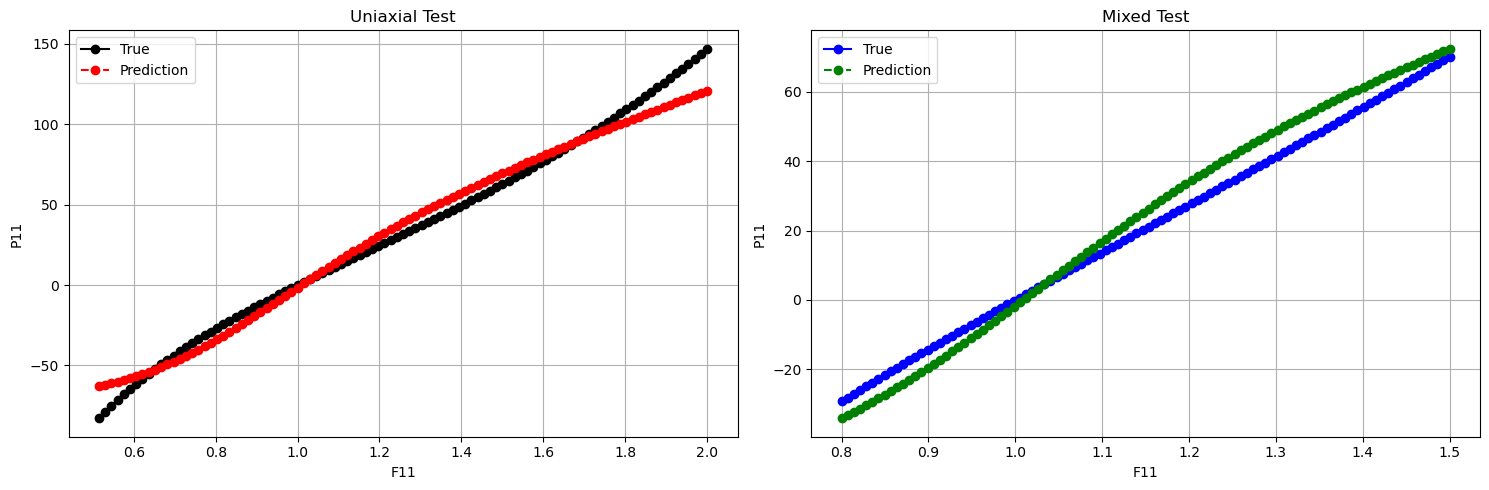

In [59]:
import matplotlib.pyplot as plt


def plot_all_stress_vs_deformation(F_biaxial_test, P_biaxial_test, P_biaxial_test_pred, 
                                 F_mixed_test, P_mixed_test, P_mixed_test_pred):

    F11_biaxial_test = F_biaxial_test[:, 0, 0]
    P11_biaxial_test = P_biaxial_test[:, 0, 0]
    P11_biaxial_test_pred = P_biaxial_test_pred[:, 0, 0]

    F11_mixed_test = F_mixed_test[:, 0, 0]
    P11_mixed_test = P_mixed_test[:, 0, 0]
    P11_mixed_test_pred = P_mixed_test_pred[:, 0, 0]


    # 创建一个包含三个子图的图形
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # 绘制双轴加载
    ax1.plot(F11_biaxial_test, P11_biaxial_test, label="True", marker="o", linestyle="-", color="black")
    ax1.plot(F11_biaxial_test, P11_biaxial_test_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax1.set_xlabel("F11")
    ax1.set_ylabel("P11")
    ax1.set_title("Uniaxial Test")
    ax1.legend()
    ax1.grid(True)

    # 绘制纯剪切加载
    ax2.plot(F11_mixed_test, P11_mixed_test, label="True", marker="o", linestyle="-", color="blue")
    ax2.plot(F11_mixed_test, P11_mixed_test_pred, label="Prediction", marker="o", linestyle="--", color="green")
    ax2.set_xlabel("F11")
    ax2.set_ylabel("P11")
    ax2.set_title("Mixed Test")
    ax2.legend()
    ax2.grid(True)

    # 调整子图之间的间距
    plt.tight_layout()
    plt.show()

# 调用函数绘制三种加载路径的结果
plot_all_stress_vs_deformation(F_biaxial_test, P_biaxial_test, P_biaxial_test_pred, 
                             F_mixed_test, P_mixed_test, P_mixed_test_pred)


### Another way 

In [72]:
# %% Own modules
import models2 as lm2
importlib.reload(lm2)
model2 = lm2.main()

model2.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 5)]          0           []                               
                                                                                                  
 input_23 (InputLayer)          [(None, 9)]          0           []                               
                                                                                                  
 private_c_f_to_w_7 (_C_F_to_W)  (None, 1)           85          ['input_22[0][0]',               
                                                                  'input_23[0][0]']               
                                                                                                  
 private_w_to_p_5 (_W_to_P)     (None, 9)            85          ['input_22[0][0]',        

In [62]:
F_train2 = F_train.reshape(-1, 9)
F_train_tensor2 = tf.convert_to_tensor(F_train2, dtype=tf.float32)
P_train2 = P_train.reshape(-1, 9)
P_train_tensor2 = tf.convert_to_tensor(P_train2, dtype=tf.float32)

In [73]:
history = model2.fit([I_train_tensor,F_train_tensor2], [W_train_tensor,P_train_tensor2], epochs=2500)

Epoch 1/2500
21/21 [==============================] - 1s 7ms/step - loss: 1087.9258 - private_c_f_to_w_7_loss: 640.3810 - private_w_to_p_5_loss: 447.5447
Epoch 2/2500
21/21 [==============================] - 0s 6ms/step - loss: 1077.9980 - private_c_f_to_w_7_loss: 630.7859 - private_w_to_p_5_loss: 447.2121
Epoch 3/2500
21/21 [==============================] - 0s 6ms/step - loss: 1066.8330 - private_c_f_to_w_7_loss: 619.9859 - private_w_to_p_5_loss: 446.8472
Epoch 4/2500
21/21 [==============================] - 0s 6ms/step - loss: 1050.4929 - private_c_f_to_w_7_loss: 603.9848 - private_w_to_p_5_loss: 446.5082
Epoch 5/2500
21/21 [==============================] - 0s 6ms/step - loss: 1026.2557 - private_c_f_to_w_7_loss: 580.0902 - private_w_to_p_5_loss: 446.1655
Epoch 6/2500
21/21 [==============================] - 0s 6ms/step - loss: 993.0456 - private_c_f_to_w_7_loss: 547.2584 - private_w_to_p_5_loss: 445.7871
Epoch 7/2500
21/21 [==============================] - 0s 6ms/step - loss: 946

In [76]:
W_uniaxial_pred, P_uniaxial_pred = model2([I_train_uniaxial, F_uniaxial.reshape(-1, 9)])

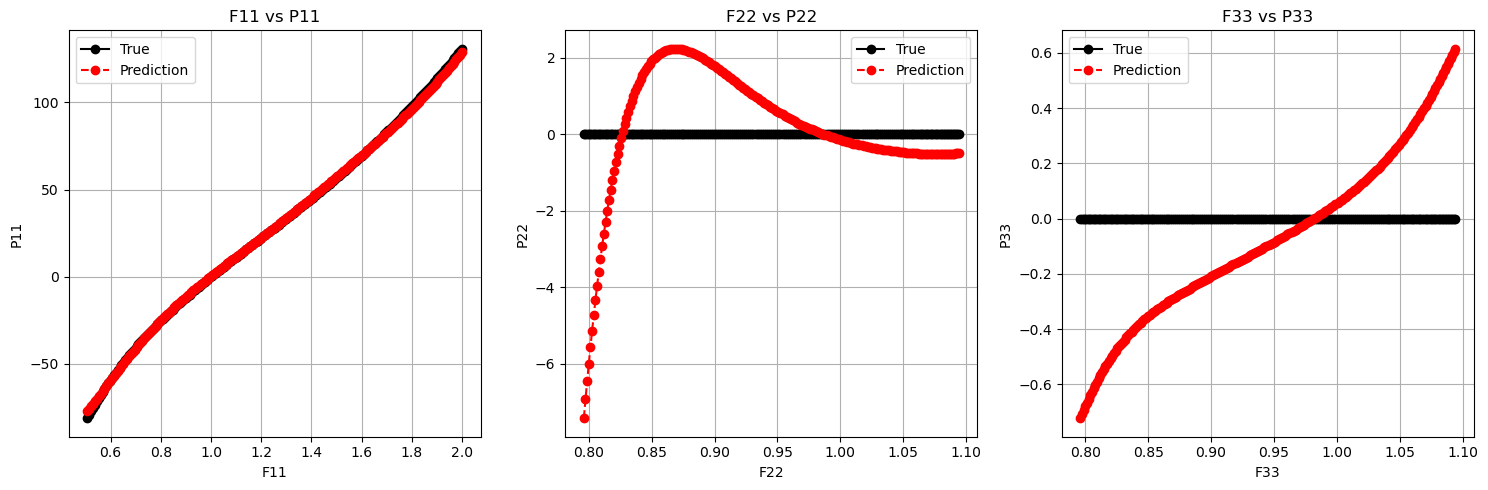

In [78]:
def plot_all_stress_vs_deformation(F_uniaxial, P_uniaxial, P_uniaxial_pred):
    P_uniaxial_pred = P_uniaxial_pred.numpy().reshape(-1, 3, 3)
    # 提取 F 和 P 的不同分量
    F11 = F_uniaxial[:, 0, 0]  # 第一列
    F22 = F_uniaxial[:, 1, 1]  
    F33 = F_uniaxial[:, 2, 2] # 第三列

    P11 = P_uniaxial[:, 0, 0]  # 原始 P 的 11 元素
    P22 = P_uniaxial[:, 1, 1]  # 原始 P 的 22 元素
    P33 = P_uniaxial[:, 2, 2]  # 原始 P 的 33 元素

    P11_pred = P_uniaxial_pred[:, 0, 0]  # 预测 P 的 11 元素
    P22_pred = P_uniaxial_pred[:, 1, 1]  # 预测 P 的 22 元素
    P33_pred = P_uniaxial_pred[:, 2, 2]  # 预测 P 的 33 元素

    # 创建绘图
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    ax1 = axes[0]
    ax2 = axes[1]
    ax3 = axes[2]

    ax1.plot(F11, P11, label="True", marker="o", linestyle="-", color="black")
    ax1.plot(F11, P11_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax1.set_xlabel("F11")
    ax1.set_ylabel("P11")
    ax1.set_title("F11 vs P11")
    ax1.legend()
    ax1.grid(True)

    ax2.plot(F22, P22, label="True", marker="o", linestyle="-", color="black")
    ax2.plot(F22, P22_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax2.set_xlabel("F22")
    ax2.set_ylabel("P22")
    ax2.set_title("F22 vs P22")
    ax2.legend()
    ax2.grid(True)

    ax3.plot(F33, P33, label="True", marker="o", linestyle="-", color="black")
    ax3.plot(F33, P33_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax3.set_xlabel("F33")
    ax3.set_ylabel("P33")
    ax3.set_title("F33 vs P33")
    ax3.legend()
    ax3.grid(True)

    # 调整布局
    plt.tight_layout()
    plt.show()

# 调用函数
plot_all_stress_vs_deformation(F_uniaxial, P_uniaxial, P_uniaxial_pred)


In [80]:
W_biaxial_test_pred , P_biaxial_test_pred = model2([I_test_biaxial, F_biaxial_test.reshape(-1, 9)])
W_mixed_test_pred , P_mixed_test_pred = model2([I_test_mixed, F_mixed_test.reshape(-1, 9)])

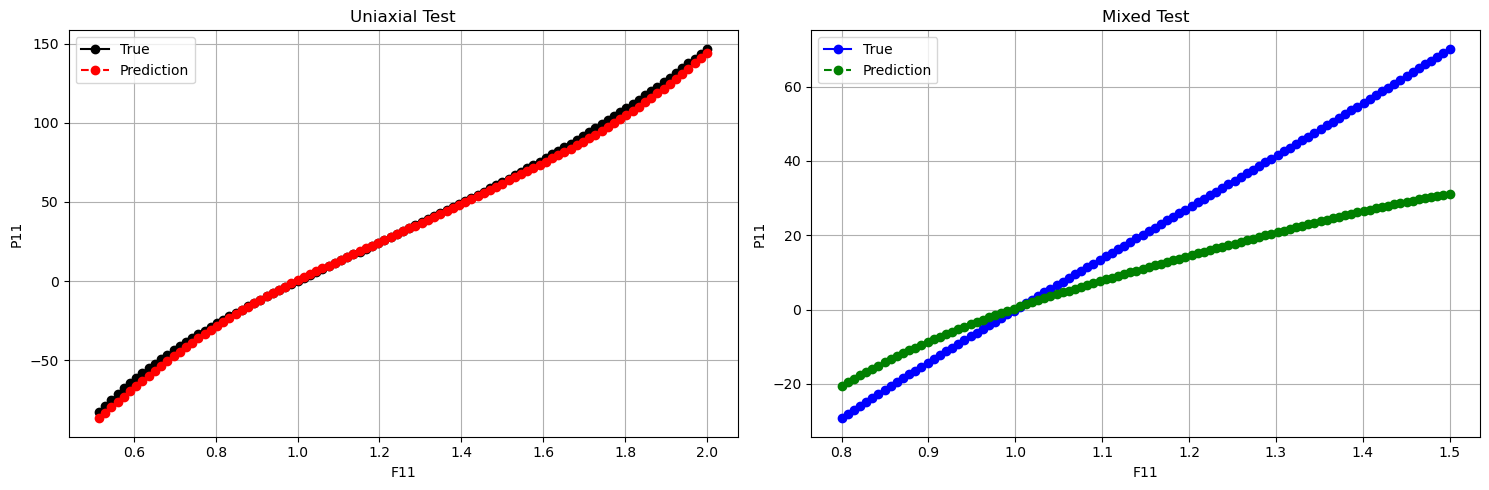

In [81]:

def plot_all_stress_vs_deformation(F_biaxial_test, P_biaxial_test, P_biaxial_test_pred, 
                                 F_mixed_test, P_mixed_test, P_mixed_test_pred):
    P_biaxial_test_pred = P_biaxial_test_pred.numpy().reshape(-1, 3, 3)
    P_mixed_test_pred = P_mixed_test_pred.numpy().reshape(-1, 3, 3)
    F11_biaxial_test = F_biaxial_test[:, 0, 0]
    P11_biaxial_test = P_biaxial_test[:, 0, 0]
    P11_biaxial_test_pred = P_biaxial_test_pred[:, 0, 0]

    F11_mixed_test = F_mixed_test[:, 0, 0]
    P11_mixed_test = P_mixed_test[:, 0, 0]
    P11_mixed_test_pred = P_mixed_test_pred[:, 0, 0]


    # 创建一个包含三个子图的图形
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # 绘制双轴加载
    ax1.plot(F11_biaxial_test, P11_biaxial_test, label="True", marker="o", linestyle="-", color="black")
    ax1.plot(F11_biaxial_test, P11_biaxial_test_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax1.set_xlabel("F11")
    ax1.set_ylabel("P11")
    ax1.set_title("Uniaxial Test")
    ax1.legend()
    ax1.grid(True)

    # 绘制纯剪切加载
    ax2.plot(F11_mixed_test, P11_mixed_test, label="True", marker="o", linestyle="-", color="blue")
    ax2.plot(F11_mixed_test, P11_mixed_test_pred, label="Prediction", marker="o", linestyle="--", color="green")
    ax2.set_xlabel("F11")
    ax2.set_ylabel("P11")
    ax2.set_title("Mixed Test")
    ax2.legend()
    ax2.grid(True)

    # 调整子图之间的间距
    plt.tight_layout()
    plt.show()

# 调用函数绘制三种加载路径的结果
plot_all_stress_vs_deformation(F_biaxial_test, P_biaxial_test, P_biaxial_test_pred, 
                             F_mixed_test, P_mixed_test, P_mixed_test_pred)